In [1]:
%matplotlib inline

import glob
from PIL import Image
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import shutil
import skimage.io as io

In [2]:
TRAIN_PATH = 'data/Train/'
TEST_PATH = 'data/Test/'
VALIDATION_PATH = 'data/Validation/'

### Dataset Sizes

In [3]:
def set_size_summary(base_dir, subsets=['']):
    num_images = 0
    for subset in subsets:
        for class_folder in os.listdir(base_dir):
            if subset:
                imgs_paths = glob.glob(f'{base_dir}{class_folder}/{subset}/*.ppm')
            else:
                imgs_paths = glob.glob(f'{base_dir}{class_folder}/*.ppm')        
            imgs_count = len(imgs_paths)
            num_images += imgs_count
            print(f'{imgs_count} images of class {class_folder}.')
    print(f'\nTotal number of images: {num_images}')

In [4]:
def plot_sample_paths(base_dir):
    paths = glob.glob(f'{base_dir}**/*.ppm', recursive=True)
    samples = np.random.choice(paths, 3, replace=False)
    fig=plt.figure(figsize=(10, 10))
    for n, sample in enumerate(samples, 1):
        fig.add_subplot(1, 3, n)
        img = plt.imread(sample)
        plt.imshow(img)
    plt.show();

- Training Set

Checking training set class distribution:

In [5]:
!ls {TRAIN_PATH}

A  B  C  Five  Point  V


In [6]:
set_size_summary(TRAIN_PATH)

572 images of class C.
1329 images of class A.
1395 images of class Point.
654 images of class Five.
435 images of class V.
487 images of class B.

Total number of images: 4872


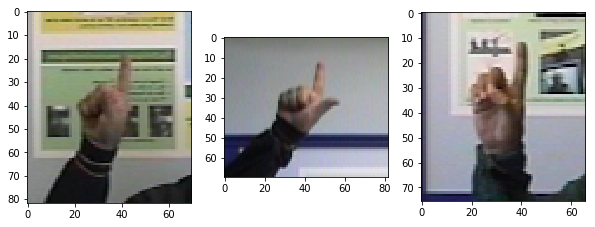

In [26]:
plot_sample_paths(TRAIN_PATH)

- Test Set

And also our test set distribution:

In [27]:
!ls {TEST_PATH}

A  B  C  Five  Point  V


In [28]:
set_size_summary(TEST_PATH, subsets=['complex', 'uniform'])

47 images of class C.
39 images of class A.
54 images of class Point.
58 images of class Five.
38 images of class V.
41 images of class B.
65 images of class C.
58 images of class A.
65 images of class Point.
76 images of class Five.
57 images of class V.
61 images of class B.

Total number of images: 659


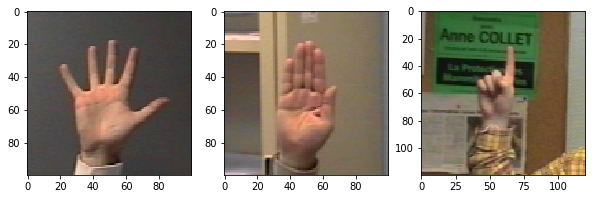

In [29]:
plot_sample_paths(TEST_PATH)

### Create Validation Set

Creating a validation set from training set:

In [30]:
for class_folder in os.listdir(TRAIN_PATH):
    imgs_paths = glob.glob(f'{TRAIN_PATH}{class_folder}/*.ppm')
    np.random.shuffle(imgs_paths)
    if not os.path.exists(f'{VALIDATION_PATH}'):
        os.mkdir(f'{VALIDATION_PATH}')
    if not os.path.exists(f'{VALIDATION_PATH}{class_folder}/'):
        os.mkdir(f'{VALIDATION_PATH}{class_folder}/')
    for image_path in imgs_paths[:int(len(imgs_paths)*0.2)]:
        shutil.move(image_path, os.path.join(f'{VALIDATION_PATH}{class_folder}', os.path.basename(image_path)))

In [31]:
set_size_summary(TRAIN_PATH)

893 images of class C.
893 images of class A.
893 images of class Point.
893 images of class Five.
893 images of class V.
893 images of class B.

Total number of images: 5358


In [32]:
set_size_summary(VALIDATION_PATH)

502 images of class C.
502 images of class A.
502 images of class Point.
502 images of class Five.
502 images of class V.
502 images of class B.

Total number of images: 3012


### Balancing Datasets

We should have the same amount of samples of each class to avoid introducing bias in the training process:

In [33]:
def count_samples(base_dir):
    class_size = {}
    for class_folder in os.listdir(base_dir):
        class_size[class_folder] = len(glob.glob(f'{base_dir}{class_folder}/*.ppm'))
    return class_size

In [34]:
sizes = count_samples(TRAIN_PATH)
sizes

{'C': 893, 'A': 893, 'Point': 893, 'Five': 893, 'V': 893, 'B': 893}

In [35]:
target_number = max(sizes.values())
target_number

893

In [36]:
unique_id = 0
for class_folder in os.listdir(TRAIN_PATH):
    imgs_paths = glob.glob(f'{TRAIN_PATH}{class_folder}/*.ppm')
    for _ in range(len(imgs_paths), target_number):
        img = io.imread(np.random.choice(imgs_paths))
        io.imsave(f'{TRAIN_PATH}{class_folder}/artificial-{unique_id}.ppm', img)
        unique_id += 1

In [37]:
count_samples(TRAIN_PATH)

{'C': 893, 'A': 893, 'Point': 893, 'Five': 893, 'V': 893, 'B': 893}

### Image dimensions

Let's find the average dimensions of the images in the dataset so we can resize them with minimum distortions:

In [38]:
def load_collection(dirs):
    imgs = io.ImageCollection(dirs)
    return imgs

In [39]:
train_imgs = load_collection(glob.glob(f'{TRAIN_PATH}/**/*.ppm'))
dims = np.array([[h.shape[0], h.shape[1]] for h in train_imgs])

In [40]:
dims.shape

(5358, 2)

In [41]:
np.mean(dims[:,0]), np.mean(dims[:,1]), np.std(dims[:,0]), np.std(dims[:,1])

(93.078574094811501,
 85.451847704367296,
 50.543610609110537,
 61.356096380300229)

In [42]:
np.max(dims[:,0]), np.min(dims[:,0])

(320, 64)

In [43]:
np.max(dims[:,1]), np.min(dims[:,1])

(384, 56)

In [44]:
mean_h, mean_w = int(np.mean(dims[:,0])), int(np.mean(dims[:,1]))
mean_h, mean_w

(93, 85)